Dependencies

In [5]:
!pip install gymnax
!pip install distrax

# Exploration

In [6]:
from gymnax.experimental import RolloutWrapper
# action = self.model_forward(policy_params, obs, rng_net)
import functools
import gymnax
from typing import Union,Optional,Any
import abc

import jax
import jax.numpy as jnp
from flax import nnx

class UnsupervisedExplorer(nnx.Module):

    @abc.abstractmethod
    def update(self,obs,actions,next_obs,dones,info):
      #update variable parameters
        return #{"kl":KL} MI = E KL

    @abc.abstractmethod
    def __call__(self,observations,rng):

        return #actions, {"mi":mi_matrix}

from gymnax.environments.environment import Environment
class CustomRolloutWrapper:
    """Wrapper to define batch evaluation for generation parameters."""

    def __init__(
        self,
        env_or_name: Union[str,Environment] = "Pendulum-v1",
        num_env_steps: Optional[int] = None,
        env_kwargs: Any | None = None,
        env_params: Any | None = None,
    ):
        """Wrapper to define batch evaluation for generation parameters."""
        # Define the RL environment & network forward function
        if env_kwargs is None:
            env_kwargs = {}
        if env_params is None:
            env_params = {}
        if isinstance(env_or_name,Environment):
            self.env = env_or_name
            self.env_params = env_or_name.default_params
        else:
            self.env, self.env_params = gymnax.make(env_or_name, **env_kwargs)
        self.env_params = self.env_params.replace(**env_params)

        if num_env_steps is None:
            self.num_env_steps = self.env_params.max_steps_in_episode
        else:
            self.num_env_steps = num_env_steps

#    @functools.partial(nnx.jit, static_argnums=(0,))
    def batch_reset(self,rng_input):
        batch_reset = jax.vmap(self.single_reset_state)
        return batch_reset(rng_input)

 #   @functools.partial(nnx.jit, static_argnums=(0,))
    def single_reset_state(self,rng_input):
        rng_reset, rng_episode = jax.random.split(rng_input)
        obs, state = self.env.reset(rng_reset, self.env_params)
        return state

   # @functools.partial(nnx.jit, static_argnums=(0,4))
    def batch_rollout(self, rng_eval, model:UnsupervisedExplorer,
                      env_state=None,num_steps=1):
        """Evaluate a generation of networks on RL/Supervised/etc. task."""
        # vmap over different MC fitness evaluations for single network
        batch_rollout = jax.vmap(self.single_rollout, in_axes=(0, None,0,None))
        return batch_rollout(rng_eval, model, env_state,num_steps)

    # @functools.partial(nnx.jit, static_argnums=(0,4))
    def single_rollout(self, rng_input, model:UnsupervisedExplorer,
                       env_state=None,num_steps=1):
        """Rollout a pendulum episode with lax.scan."""
        # Reset the environment
        rng_reset, rng_episode = jax.random.split(rng_input)

        if env_state is None:
            obs, env_state = self.env.reset(rng_reset, self.env_params)
        else:
            obs = self.env.get_obs(env_state)

        def policy_step(state_input, _):
            """lax.scan compatible step transition in jax env."""
            obs, state,  rng, cum_reward, valid_mask = state_input
            rng, rng_step, rng_net = jax.random.split(rng, 3)
            if model is not None:
                action,info = model(obs, rng_net)
            else:
                action = self.env.action_space(self.env_params).sample(rng_net)
                info = {}
        #    print ("policy step action",action.shape)
            next_obs, next_state, reward, done, step_info = self.env.step(
                rng_step, state, action, self.env_params
            )
            info.update(step_info)
            new_cum_reward = cum_reward + reward * valid_mask
            new_valid_mask = valid_mask * (1 - done)
            carry = [
                next_obs,
                next_state,
                rng,
                new_cum_reward,
                new_valid_mask,
            ]
            y = [obs, action, reward, next_obs, done, state, info]
            return carry, y

        # Scan over episode step loop
        carry_out, scan_out = jax.lax.scan(
            policy_step,
            [
                obs,
                env_state,
                rng_episode,
                jnp.array([0.0]),
                jnp.array([1.0]),
            ],
            (),
            num_steps,
        )
        # Return the sum of rewards accumulated by agent in episode rollout
        obs, action, reward, next_obs, done, state, info = scan_out
        cum_return = carry_out[-2]
        info["last_state"] = carry_out[1]
        return obs, action, reward, next_obs, done,state, info, cum_return

class UnsupervisedRolloutWrapper(CustomRolloutWrapper):

 #   @functools.partial(nnx.jit, static_argnums=(0,))
    def batch_update(self, rng_update,model, obs, action,next_obs,done,info):
        if model is None: return {}
        return model.update(rng_update,obs, action,next_obs,done,info)


In [7]:
import jax
import jax.numpy as jnp
import jax.nn as nn
from flax import nnx

jnp.set_printoptions(precision=3,suppress=True)
from flax.training import train_state
from jax.scipy.special import gamma,digamma, gammaln, kl_div

def batch_random_split(batch_key,num=2):
    split_keys = jax.vmap(jax.random.split,in_axes=(0,None))(batch_key,num)
    return [split_keys[:, i]  for i in range(num) ]
@jax.jit
def compute_info_gain_normal(mean,prec,l_prec, next_obs):
    """
    mean: (batch, obs_dim)
    prec: (batch, obs_dim)  N(u;mean(s,a),(prec(s,a))^-0.5) N(next_obs;u,(l_prec(s,a))^-0.5)
    l_prec: (batch, obs_dim)    likelihood_precision
    next_obs: (batch, obs_dim)

    output: (batch)
    """

    prec = jnp.maximum(prec, 1e-6)
    posteior_prec = prec + l_prec
    prec_ratio = prec / posteior_prec

    posterior_mean = (prec * mean + next_obs * l_prec) /posteior_prec

    delta_mean =  next_obs - posterior_mean

    kl  = delta_mean * delta_mean * prec   #* ( l_prec / posteior_prec ) ** 2
    kl = kl + prec_ratio - jnp.log(prec_ratio) - 1
    kl = 0.5 * jnp.sum(kl,axis=-1)
    return kl, delta_mean

@jax.jit
def compute_expected_info_gain_normal(prec,l_prec):
    """
    prec: (batch, obs_dim)
    l_prec: (batch, obs_dim)    likelihood_precision

    output: (batch)
    """


    prec = jnp.maximum(prec, 1e-6)
    prec_ratio = l_prec / prec
    mi_matrix = 0.5 * jnp.sum( jnp.log(1+prec_ratio),axis=-1)
    return mi_matrix


class JointEncoder(nnx.Module):
    def __init__(self, hidden_dims: int, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(hidden_dims,hidden_dims,rngs=rngs)
        self.linear2 = nnx.Linear(hidden_dims,hidden_dims,rngs=rngs)
        self.layer_norm0 = nnx.LayerNorm(hidden_dims,rngs=rngs)
        self.layer_norm1 = nnx.LayerNorm(hidden_dims,rngs=rngs)
        self.layer_norm2 = nnx.LayerNorm(hidden_dims,rngs=rngs)
        self.layer_norm3 = nnx.LayerNorm(hidden_dims,rngs=rngs)

    def __call__(self, x: jax.Array,rng):


        dist_distrax =  distrax.MultivariateNormalDiag(x,1e-1*jnp.ones_like(x))
        x = dist_distrax.sample(seed=rng, sample_shape=())
        x = self.layer_norm0(x)
        h0 = self.linear1(x)
        h = nn.relu(h0)
        h = self.layer_norm1(h) +h0
        h0 = self.linear2(h)
        h = self.layer_norm2(h)+h0
        return  self.layer_norm3(h)

class Encoder(nnx.Module):
    def __init__(self, input_dim: int, hidden_dims: int, rngs: nnx.Rngs):
        self.linear = nnx.Linear(input_dim,hidden_dims,rngs=rngs)
        self.layer_norm0 = nnx.LayerNorm(hidden_dims,rngs=rngs)

    def __call__(self, x: jax.Array):
        h = self.linear(x)
        return  self.layer_norm0(h)

class ActionEncoder(nnx.Module):
    def __init__(self, num_actions: int, hidden_dims: int, rngs: nnx.Rngs):
        self.embed = nnx.Embed(num_actions,hidden_dims,rngs=rngs)
        self.layer_norm0 = nnx.LayerNorm(hidden_dims,rngs=rngs)
    def __call__(self, x: jax.Array):
        return  self.layer_norm0(self.embed(x))

from jax import lax
import distrax

class Actor(nnx.Module):
    log_std_min: float = -4
    log_std_max: float = 2

    def __init__(self, obs_dim, action_dim,hidden_dim, rngs: nnx.Rngs):

        self.linear = nnx.Linear(obs_dim, hidden_dim, rngs=rngs)

        self.action_head = nnx.Linear(hidden_dim, action_dim, rngs=rngs)

   #     self.linear1 = nnx.Linear(hidden_dim, action_dim, rngs=rngs)

    def __call__(self, x: jnp.ndarray):
        x = self.linear(x)
        logits = self.action_head(x)
        pi = distrax.Categorical(logits=logits)
        return pi

class MLP(nnx.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, rngs):
        self.linear1 = nnx.Linear(input_dim, hidden_dim, rngs=rngs)
        self.linear2 = nnx.Linear(hidden_dim, output_dim, rngs=rngs)

    def __call__(self, x):
        h = jax.nn.relu(self.linear1(x))
        return self.linear2(h)


class Likelihood_Prec(nnx.Module):
    log_std_min: float = -2
    log_std_max: float = 2

    def __init__(self, obs_dim, hidden_dim, rngs: nnx.Rngs):

        self.linear = nnx.Linear(hidden_dim, obs_dim, rngs=rngs)
   #     self.linear1 = nnx.Linear(hidden_dim, action_dim, rngs=rngs)

    def __call__(self, x: jnp.ndarray):
        log_std = self.linear(x)
        log_std = jnp.clip(log_std, self.log_std_min, self.log_std_max)
        return jnp.exp(-log_std)


def show_variable(model,text):

    graphdef, params, vars,others = nnx.split(model, nnx.Param, nnx.Variable,...)

    print(text,vars)



disagreement

In [35]:
class TwinCritic(nnx.Module):
    def __init__(self, input_dim, hidden_dim, rngs: nnx.Rngs):
        @nnx.split_rngs(splits=2)
        @nnx.vmap(in_axes=0, out_axes=0)
        def create_model(rngs):
          model = nnx.Sequential(
                  nnx.Linear(input_dim, hidden_dim, rngs=rngs),
                  nnx.relu,
                  nnx.Linear( hidden_dim,1, rngs=rngs)
                )
          return model
        self.qs1 = nnx.Sequential(
                  nnx.Linear(input_dim, hidden_dim, rngs=rngs),
                  nnx.relu,
                  nnx.Linear( hidden_dim,1, rngs=rngs)
                )
        self.qs2 = nnx.Sequential(
                  nnx.Linear(input_dim, hidden_dim, rngs= nnx.Rngs(2)),
                  nnx.relu,
                  nnx.Linear( hidden_dim,1, rngs= nnx.Rngs(2))
                )

    def __call__(self, x: jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray]:
        #@nnx.vmap(in_axes=(0, None), out_axes=0)
       # def forward(model, x):
      #    return model(x)
     #   qs =  forward(self.qs,x)
        return self.qs1(x),self.qs2(x)



class Disagreement(nnx.Module):
  def __init__(self, obs_dim, action_dim, hidden_dim, rngs, n_models=20):
    self.n_models = n_models
    self.obs_dim = obs_dim

    @nnx.split_rngs(splits=n_models)
    @nnx.vmap(in_axes=0, out_axes=0)
    def create_model(rngs):
      model = nnx.Sequential(
              nnx.Linear(obs_dim + action_dim, hidden_dim, rngs=rngs),
              nnx.relu,
              nnx.Linear( hidden_dim,obs_dim, rngs=rngs)
            )
      return model
    self.ensemble = create_model(rngs)

  def _get_preds(self,inputs):
    @nnx.vmap(in_axes=(0, None), out_axes=0)
    def forward(model, x):
      return model(x)
    return forward(self.ensemble,inputs)

  def __call__(self, obs, actions, next_obs):
    errors = []
    inputs = jnp.concatenate([obs, actions], axis=-1)

    next_obs_hat = self._get_preds(inputs)
    next_obs = jnp.expand_dims(next_obs, axis=0)
    model_err = jnp.linalg.norm(next_obs - next_obs_hat, axis=-1, keepdims=True)

    return model_err

  def get_disagreement(self, obs, actions):
    inputs = jnp.concatenate([obs, actions], axis=-1)

    next_obs_hat = self._get_preds(inputs)

    return jnp.var(next_obs_hat, axis=0).mean(axis=-1)

  def get_preds(self,obs, actions):
    inputs = jnp.concatenate([obs, actions], axis=-1)
    @nnx.vmap(in_axes=(0, None), out_axes=0)
    def forward(model, x):
      return model(x)
    return forward(self.ensemble,inputs)

class DisagreementExplorer(UnsupervisedExplorer):
  def __init__(self, obs_dim, num_actions, hidden_dim, rngs):
    self.trainable_actor = Actor(obs_dim, num_actions, hidden_dim, rngs)
    self.trainable_critic = TwinCritic(obs_dim + num_actions, hidden_dim, rngs)
    self.trainable_critic_target = nnx.clone(self.trainable_critic)
    self.trainable_disagreement = Disagreement(obs_dim, num_actions, hidden_dim, rngs)

    self.obs_dim = obs_dim
    self.hidden_dim = hidden_dim

    self.num_actions = num_actions

  def __call__(self, observations, rng):
    return self.get_action(observations), {}

  def get_action(self, observations):
      if len(observations.shape) == 1:
        return self.get_single_action( observations)
      else:
        return jax.vmap(self.get_action)(observations)
  def get_single_action(self, observations):
      #observations obs_dim
      #num_actions x num_actions

      actions = jax.nn.one_hot(jnp.arange(self.num_actions), num_classes=self.num_actions, axis=-1)
      observations = jnp.repeat(jnp.expand_dims(observations, axis=0),self.num_actions, axis=0)
      q1,q2 = self.trainable_critic_target(jnp.concatenate([observations, actions], axis=-1))
      #num_actions x 1
      qmin = jnp.minimum(q1,q2)
      print("qmin:", qmin.shape)
      qmin = jnp.squeeze(qmin, axis=-1)
      key = jax.random.PRNGKey(seed=42)
      pi = distrax.Categorical(logits=qmin)
      action = pi.sample(seed=key)
      print("action", action.shape)

      # action = jnp.squeeze(jnp.argmax(qmin,axis=0),axis=-1)
      return action

  def update(self,rng,obs,actions,next_obs,dones,info,tau=0.05):
    actions = jax.nn.one_hot(actions, num_classes=self.num_actions, axis=-1)
    reward = self.trainable_disagreement.get_disagreement(obs, actions)

    error = self.trainable_disagreement(obs, actions, next_obs)
    loss = jnp.mean(error)

    _, c_params = nnx.split(self.trainable_critic)
    t_graphdef, t_params = nnx.split(self.trainable_critic_target)

    new_t_params = jax.tree_map(lambda p, tp: p * tau + tp * (1 - tau), c_params, t_params)
    self.trainable_critic_target = nnx.merge(t_graphdef, new_t_params)
    tq1, tq2 = self.trainable_critic_target(jnp.concatenate([obs*0, actions*0], axis=-1))

    return {"disagreement": reward, "model_err": loss, "q1": tq1}

  def batch_disagreement_loss(self, rng_loss, obs, actions,next_obs,done,info):
    actions = jax.nn.one_hot(actions, num_classes=self.num_actions, axis=-1)
    error = self.trainable_disagreement(obs, actions, next_obs)
    loss = jnp.mean(error)
    return loss

  def compute_intr_reward(self, obs, actions):
    actions = jax.nn.one_hot(actions, num_classes=self.num_actions, axis=-1)
    reward = self.trainable_disagreement.get_disagreement(obs, actions)
    return jnp.expand_dims(reward, axis=-1)

  def batch_critic_loss(self, rng_act, obs, actions, next_obs, dones, info):
    reward = jax.lax.stop_gradient(self.compute_intr_reward(obs, actions))

    print ("reward",reward)
    actions = jax.nn.one_hot(actions, num_classes=self.num_actions, axis=-1)
    #discount = jnp.expand_dims(info["discount"], axis=-1)

    next_actions = self.get_action( next_obs)
    next_actions = jax.nn.one_hot(next_actions, num_classes=self.num_actions, axis=-1)

    tq1, tq2 = self.trainable_critic_target(jnp.concatenate([next_obs, next_actions], axis=-1))
    target_v = jnp.minimum(tq1, tq2)

    target_q = reward + 0.9 * jnp.expand_dims((1-dones),-1)* target_v
    q1, q2 = self.trainable_critic(jnp.concatenate([obs, actions], axis=-1))
    mse1 = (q1 - target_q) ** 2
    mse2 = (q2 - target_q) ** 2
    loss = jnp.mean(mse1 + mse2)

    return loss


obs_dim, num_actions, hidden_dim,rngs = 3,2,4 , nnx.Rngs(1)
model = DisagreementExplorer(obs_dim, num_actions, hidden_dim, rngs)



{'NUM_ENVS': 4, 'WD': 0.1, 'NUM_STEPS': 16, 'SAC_D_STEPS': 4, 'ENV_NAME': 'CartPole-v1', 'SAC_STEP_SIZE': 1.0, 'SEED': 423, 'TOTAL_TIMESTEPS': 16384, 'NUM_HIDDEN': 128, 'TX': 'adamw', 'DEPTH': 1, 'LR': 0.0002, 'MODEL_NAME': 'DisagreementExplorer', 'DEBUG': False}
low [-4.80e+00 -3.40e+38 -4.19e-01 -3.40e+38]
high [4.80e+00 3.40e+38 4.19e-01 3.40e+38]
qmin: (2, 1)
action ()
reward Traced<ShapedArray(float32[4,16,1])>with<DynamicJaxprTrace>
qmin: (2, 1)
action ()
data shape: Transition(obs=(256, 4, 16, 4), action=(256, 4, 16), reward=(256, 4, 16), next_obs=(256, 4, 16, 4), done=(256, 4, 16), info={'disagreement': (256, 4, 16), 'discount': (256, 4, 16), 'last_state': EnvState(time=(256, 4), x=(256, 4), x_dot=(256, 4), theta=(256, 4), theta_dot=(256, 4)), 'model_err': (256,), 'q1': (256, 4, 16, 1), 'reward': (256, 4, 16)})


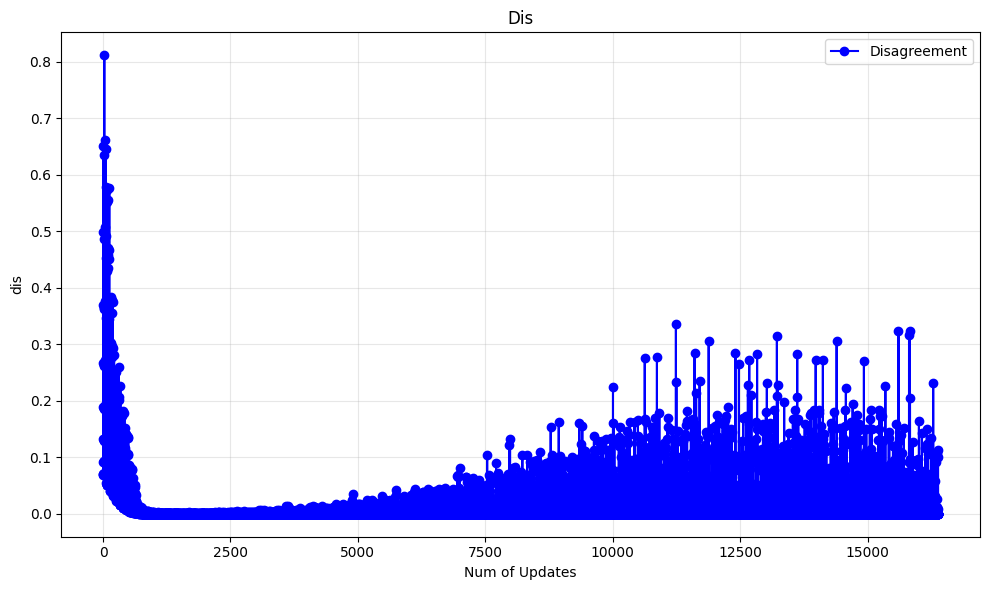

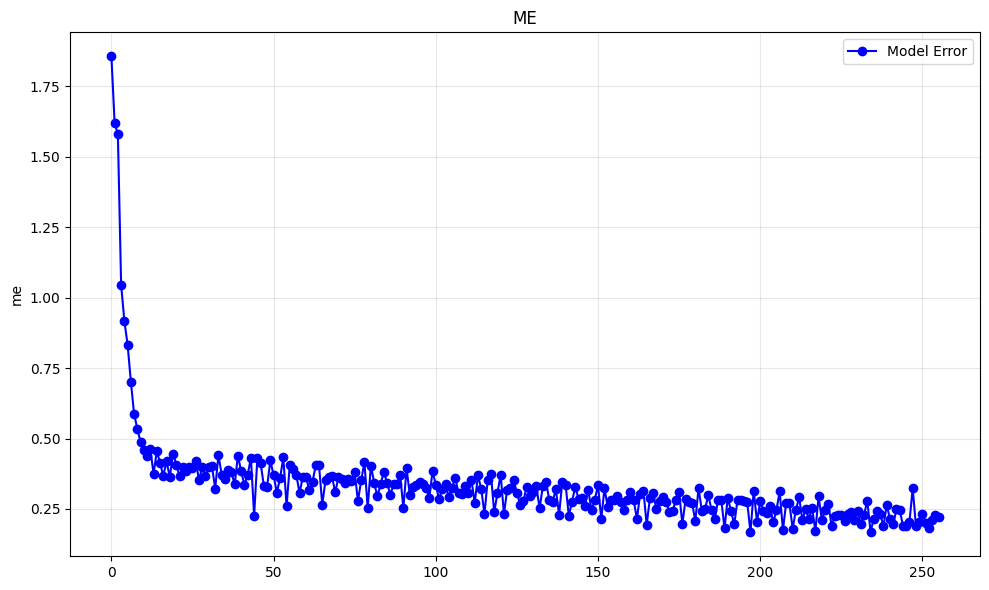

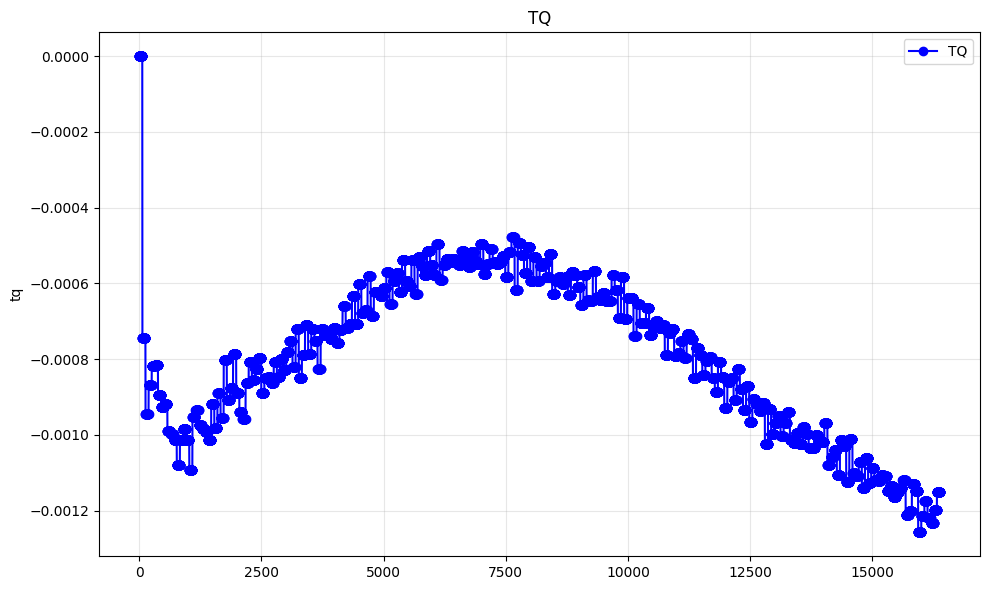

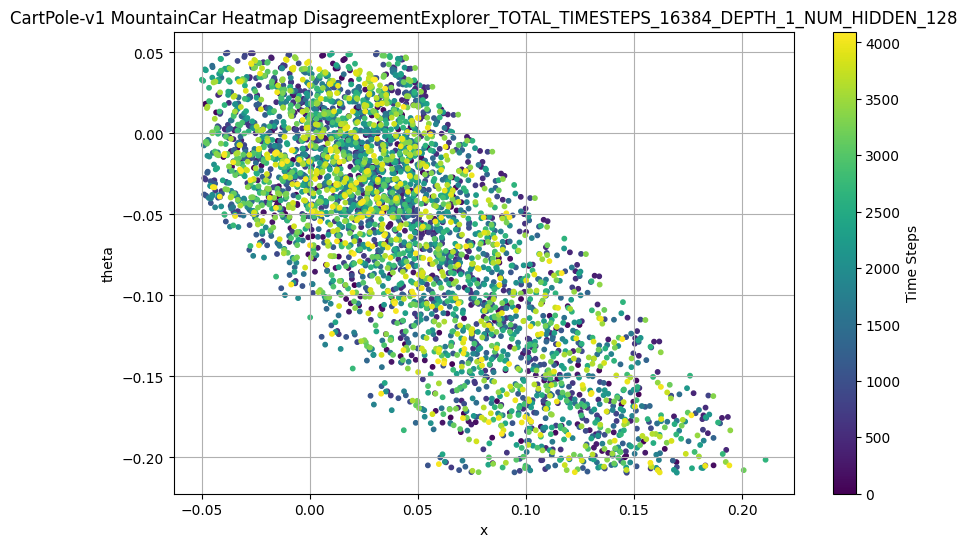

In [37]:
# NUM_UPDATES x NUM_ENVS x NUM_STEPS
class Transition(NamedTuple):
    obs: jnp.ndarray
    action: jnp.ndarray
    reward: jnp.ndarray
    next_obs: jnp.ndarray
    done: jnp.ndarray
    info: {}

env_name = 'CartPole-v1'  # @param ['CartPole-v1',"MountainCar-v0","Acrobot-v1"]
NUM_ENVS = 4 # @param [1,2,4,8,16,32] {"type":"raw"}
TOTAL_TIMESTEPS = 16384 # @param [2048,16384,131072,1048576] {"type":"raw"}
DEPTH = 1 # @param [1,2,4] {"type":"raw"}
NUM_STEPS = 16 # @param [-1,1,2,4,8,16,200] {"type":"raw"}
NUM_HIDDEN = 128 # @param [32,64,128,256] {"type":"raw"}
WD = 0.1 # @param [0,0.1,0.01,0.001] {"type":"raw"}
MODEL_NAME = "DisagreementExplorer"  #@param ["DisagreementExplorer","DeepBayesianExplorer","RandomExplorer","PPOExplorer"]
config = {
    "NUM_ENVS": NUM_ENVS,    #
    "WD": WD,
    "NUM_STEPS": NUM_STEPS,   #steps of roll out between update
    "SAC_D_STEPS": 4,
    "ENV_NAME":env_name,
    "SAC_STEP_SIZE": 1.0,
    "SEED": 423,         #highly stochastic
    "TOTAL_TIMESTEPS": TOTAL_TIMESTEPS,   #total steps for all envs
    "NUM_HIDDEN":NUM_HIDDEN,
    "TX":"adamw",
    "DEPTH":DEPTH,
    "LR":2e-4,
    "MODEL_NAME": MODEL_NAME,
    "DEBUG": False,
}

out = experiment(config)

random & deepbayesian

In [11]:
class RandomExplorer(UnsupervisedExplorer):

    def __init__(self, num_actions):
        self.num_actions = num_actions

    def update(self,rng,obs,action,next_obs,done,info):
      #update variable parameters
        return {} #MI = E KL

    def __call__(self,observations,rng):
        if observations.ndim == 1:
            actions = jax.random.randint(rng, (), 0, self.num_actions)
            return actions, {}
        actions = jax.random.randint(rng, (observations.shape[0],), 0, self.num_actions)
        return actions, {}

class DeepBayesianExplorer(UnsupervisedExplorer):

    def __init__(self, obs_dim, num_actions,hidden_dim, rngs: nnx.Rngs
                 ,l_prec=1.0,weight_decay=1e-2,ent_lambda=1e-3,depth=2):
        self.obs_dim = obs_dim
        self.num_actions = num_actions
        self.hidden_dim = hidden_dim
        self.prec_w = nnx.Variable(jnp.zeros((hidden_dim, obs_dim)))
        self.mean_w = nnx.Variable(jnp.zeros((hidden_dim, obs_dim)))

        self.trainable_likelihood_prec = Likelihood_Prec(obs_dim,hidden_dim,rngs)

       # self.trainable_actor = Actor(obs_dim, action_dim,hidden_dim, rngs=rngs)

        self.weight_decay = weight_decay
        self.obs_embeds = Encoder(obs_dim,hidden_dim,rngs)
        self.action_embeds = ActionEncoder(num_actions,hidden_dim,rngs)
        self.joint_embeds =JointEncoder(hidden_dim,rngs)
        self.depth = depth
        self.ent_lambda = ent_lambda

    def update(self,rng,obs,action,next_obs,done,info):
     #   next_obs = next_obs["observation"]
        mean = info["mean"]
        prec = info["prec"]
     #   l_prec = jnp.clip( 1 / jnp.pow(mean - next_obs,2), max=10)


        def _likelihood_loss(rng, T,mean, prec,next_obs):


            # . x embed_size
            l_prec = self.trainable_likelihood_prec(T)

            mu = mean
            sigma = jnp.sqrt( 1 / l_prec + 1 / prec)

        #    print ("mean",mean.shape)
         #   print ("next_obs",next_obs.shape)
            dist_distrax =  distrax.MultivariateNormalDiag(mu,sigma)

            dist_distrax.log_prob(next_obs)

            return - dist_distrax.log_prob(next_obs), l_prec #.sum(-1)
        predictive_loss, l_prec = _likelihood_loss(rng, info["T"],mean, prec,next_obs)

        mean_error = mean - next_obs
        mean_error = mean_error * mean_error
        mean_error = jnp.sum(mean_error,axis=-1)
        deepkl, delta_mean = compute_info_gain_normal(mean,prec,l_prec, next_obs)
        #batch x  num_hidden
        T = info["T"].reshape(-1,self.hidden_dim)

        #batch x  obs_dim
        l_prec = l_prec.reshape(-1,self.obs_dim)
        delta_mean = delta_mean.reshape(-1,self.obs_dim)

        # jax.debug.print("{}", T_theta)
        T_T = jnp.transpose(T)

        covariance = T @ T_T
        inv_covariance = jnp.linalg.pinv(covariance)

        T_Map =  T_T @ inv_covariance

        delta_precW = T_Map @ l_prec
        self.prec_w.value = (self.prec_w.value + delta_precW) * (1-self.weight_decay)

        delta_meanW = T_Map @ delta_mean
        self.mean_w.value = (self.mean_w.value + delta_meanW) * (1-self.weight_decay)

        return {"kl":deepkl,"predictive_loss":predictive_loss,"mean_error":mean_error}

   # @nnx.jit
    def loss(self,rng, obs,action,next_obs,done,info):
      #  next_obs = next_obs["observation"]
        def _likelihood_loss(T,mean, prec,next_obs):


            # . x embed_size
            l_prec = self.trainable_likelihood_prec(T)

            mu = mean
            sigma = jnp.sqrt( 1 / l_prec + 1 / prec)

         #   print ("mean",mean.shape)
          #  print ("next_obs",next_obs.shape)
            dist_distrax =  distrax.MultivariateNormalDiag(mu,sigma)

        #    dist_distrax.log_prob(next_obs)

            return -dist_distrax.log_prob(next_obs) #.sum(-1)

    #    print ("sac_loss",sac_loss)
        T, mean, prec = info["T"],info["mean"],info["prec"]
        likelihood_loss = _likelihood_loss(T,mean, prec,next_obs)
     #   print ("likelihood_loss",likelihood_loss)
        return  likelihood_loss
    def batch_loss(self,rng, obs,action,next_obs,done,info):
        vmapped = jax.vmap(self.loss)
        return vmapped(rng, obs,action,next_obs,done,info)
    def __call__(self,observations,rng):
     #   print ("observations",observations.shape)
        # obs_dim
        return self.recursive_mi(observations,rng,self.depth)

    def recursive_mi(self,observations,rng,depth):
        # embed_size
        obs_embed = self.obs_embeds(observations)#.squeeze() xland embedding/one-hot+cnn
        # num_actions x act_dim
        action_embed = self.action_embeds(jnp.arange(self.num_actions))#.value
        #num_actions x embed_size   deeper NN with direct addition is equivalent to shallow NN with concate and linear layer
        embed = action_embed+jnp.expand_dims(obs_embed,0)

        # num_actions x embed_size
        T = self.joint_embeds(embed,rng)
  #     print ("T",T.shape)
        prec = jnp.maximum(T @ self.prec_w ,1e-3)
        # num_actions x obs_dim
        mean = T @ self.mean_w
        l_prec = self.trainable_likelihood_prec(T)

        # num_actions
        MI = compute_expected_info_gain_normal(prec,l_prec)

        if depth > 0:
            vmapped = jax.vmap(self.recursive_mi,in_axes=(0,None,None))
            # num_actions x 1
            actions, info = vmapped(mean,rng,depth-1)
            MI =  MI + info["mi"]

        actions = jnp.argmax(MI, axis=0)
        T = T[actions]
        MI = MI[actions]
        l_prec = l_prec[actions]
        prec = prec[actions]
        mean = mean[actions]
        return actions, {"mi":MI,"T":T,"obs_embed":obs_embed,"l_prec":l_prec,
                            "prec":prec,"mean":mean}





ppo

In [12]:
import jax
import jax.numpy as jnp
from flax import nnx
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal

class ActorCritic(nnx.Module):
    def __init__(self, obs_dim, num_actions, hidden_dim, depth, rngs: nnx.Rngs):
        self.obs_dim = obs_dim
        self.num_actions = num_actions
        self.hidden_dim = hidden_dim

        # 共享的特征提取层
        self.feature_extractor = [
            nnx.Linear(obs_dim, hidden_dim, rngs=rngs),
            nnx.tanh
        ]
        for _ in range(depth-1):
            self.feature_extractor.append(nnx.Linear(hidden_dim, hidden_dim, rngs=rngs))
            self.feature_extractor.append(nnx.tanh)

        # Actor头 (策略)
        self.actor_head = nnx.Linear(hidden_dim, num_actions, rngs=rngs)

        # Critic头 (值函数)
        self.critic_head = nnx.Linear(hidden_dim, 1, rngs=rngs)

    def __call__(self, x):
        for layer in self.feature_extractor:
            x = layer(x)
        logits = self.actor_head(x)
        pi = distrax.Categorical(logits=logits)
        value = self.critic_head(x)
        return pi, jnp.squeeze(value, axis=-1)



class PPOExplorer(UnsupervisedExplorer):
  def __init__(self, obs_dim,
                     num_actions,
                     hidden_dim,
                     rngs: nnx.Rngs,
                     depth:int = 2,
                     gamma: float = 0.99,
                     gae_lambda: float = 0.95,
                     clip_eps: float = 0.2,
                     ent_coef: float = 0.01,
                     vf_coef: float = 0.5,
                     max_grad_norm: float = 0.5,
                     num_steps: int = 128,
                     num_envs: int = 4,
                     lr: float = 2.5e-4):

    self.obs_dim = obs_dim
    self.num_actions = num_actions
    self.hidden_dim = hidden_dim
    self.depth = depth
    self.gamma = gamma
    self.gae_lambda = gae_lambda
    self.clip_eps = clip_eps
    self.ent_coef = ent_coef
    self.vf_coef = vf_coef
    self.max_grad_norm = max_grad_norm
    self.num_steps = num_steps
    self.num_envs = num_envs

    self.trainable_network = ActorCritic(obs_dim, num_actions,hidden_dim, depth, rngs)
    # self.optimizer = nnx.Optimizer(self.trainable_network, optax.adam(1e-3), wrt=nnx.Param)

  def __call__(self, observations, rng):
    pi, value = self.trainable_network(observations)

    action = pi.sample(seed=rng)
    log_prob = pi.log_prob(action)

    return action, {"log_prob": log_prob, "value": value}

  def update(self,rng,obs,actions,next_obs,dones,info):
    return {}

  def batch_loss(self, rng, obs, actions, next_obs, dones, info):

    _, value = self.trainable_network(obs)
    reward = info["reward"]
    transition = (obs, actions, next_obs, dones, reward, info)

    #GAE
    def _calculate_gae(transition, value):
      def _get_advantages(gae_and_next_value, transition):
        gae, next_value = gae_and_next_value
        obs, actions, next_obs, dones, reward, info = transition
        delta = reward + self.gamma * next_value * (1 - dones) - info["value"]
        gae = (delta + self.gamma * self.gae_lambda * (1 - dones) * gae)
        return (gae, value), gae

      _, advantages = jax.lax.scan(
            _get_advantages,
            (jnp.zeros_like(info["value"]), info["value"]),
            transition,
            reverse=True,
            unroll=16,
      )
      return advantages, advantages + info["value"]

    gae, targets = _calculate_gae(transition, value)

    #Rerun Network
    pi, next_value = self.trainable_network(next_obs)
    log_prob = pi.log_prob(actions)

    # value loss
    value_pred_clipped = value + (next_value - value).clip(-self.clip_eps, self.clip_eps)
    value_losses = jnp.square(next_value - targets)
    value_losses_clipped = jnp.square(value_pred_clipped - targets)
    value_loss = (0.5 * jnp.maximum(value_losses, value_losses_clipped).mean())

    # actor loss
    ratio = jnp.exp(log_prob - info["log_prob"])
    gae = (gae - gae.mean()) / (gae.std() + 1e-8)
    loss_actor1 = ratio * gae
    loss_actor2 = (
        jnp.clip(
            ratio,
            1.0 - self.clip_eps,
            1.0 + self.clip_eps,
        )
        * gae
    )
    loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
    loss_actor = loss_actor.mean()
    entropy = pi.entropy().mean()

    total_loss = loss_actor + self.vf_coef * value_loss - self.ent_coef * entropy

    return total_loss


Algorithm

In [38]:
import jax
import jax.numpy as jnp
jnp.set_printoptions(precision=2,suppress=True)
from jax.scipy.special import digamma, gammaln, kl_div
import flax.linen as nn
import numpy as np
import optax
import time
import flax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any, Dict
import distrax
import gymnax
import functools
from gymnax.environments import spaces
from gymnax.wrappers import FlattenObservationWrapper, LogWrapper
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

import optax
from flax.nnx.helpers import TrainState

class MyTrainState(TrainState):
    vars: nnx.Variable
    others: nnx.State

    @property
    def need_train(self):
        return len(self.params) > 0

is_trainable = lambda path, node: (
    node.type == nnx.Param and \
    any('trainable' in p_elem for p_elem in path if isinstance(p_elem, str))
)

def train_state_from_model(model,tx=optax.adam(0.02)):
    graphdef, trainable_params, vars, others = nnx.split(model,is_trainable, nnx.Variable,...)
 #   print(trainable_params)

    state = MyTrainState.create(
      tx=tx,
      graphdef=graphdef,
      params=trainable_params,
      vars=vars,
      others=others,
    )
    return state

def train_state_update_model(model,state):
    graphdef, trainable_params, vars, others = nnx.split(model,is_trainable, nnx.Variable,...)
    return state.replace(vars=vars,others=others)

def model_from_train_state(state):
    return nnx.merge(state.graphdef, state.params, state.vars,state.others)
# prompt: draw heatmap given sequence of states for MountainCar
#state.position, state.velocity
import matplotlib.pyplot as plt

def reshape(arr):
    if arr.ndim < 3:
        raise ValueError("Input array must have at least 3 dimensions (n, b, c, ...).")

    # Get the original shape components
    n, b, c, *x_dims = arr.shape

    # Transpose the first two axes (n, b) to (b, n)
    # We construct the axes tuple dynamically for flexibility
    transpose_axes = (1, 0) + tuple(range(2, arr.ndim))
    transposed_arr = jnp.transpose(arr, axes=transpose_axes)

    # Reshape into (b, n*c, x0, x1, ...)
    new_shape = (b, n * c, *x_dims)
    reshaped_arr = jnp.reshape(transposed_arr, new_shape)

    return reshaped_arr

from typing import List, Any

# Define a type alias for PyTree for better readability
PyTree = Any
def unpack_pytree_by_first_index(pytree: PyTree) -> List[PyTree]:
    """
    Unpacks a PyTree of JAX arrays along their first dimension (id).

    This function assumes that all JAX arrays within the PyTree
    have a consistent first dimension (the 'id' dimension) and that
    you want to create a separate PyTree for each 'id'.

    Args:
        pytree: A JAX PyTree where the leaves are JAX arrays
                with a leading 'id' dimension.

    Returns:
        A list of PyTrees, where each PyTree corresponds to a single
        'id' from the original PyTree.
    """
    # Get the size of the first dimension from any leaf array
    # We assume all arrays have the same first dimension size.
    first_leaf = jax.tree_util.tree_leaves(pytree)[0]
    num_ids = first_leaf.shape[0]

    # Create a list to store the unpacked PyTrees
    unpacked_pytrees = []

    # Iterate through each ID
    for i in range(num_ids):
        # Use tree_map to slice each array in the PyTree at the current ID
        sliced_pytree = jax.tree_util.tree_map(lambda x: x[i], pytree)
        unpacked_pytrees.append(sliced_pytree)

    return unpacked_pytrees
def unpack_states(pytree):
    return unpack_pytree_by_first_index(jax.tree.map(reshape, pytree))
def draw_mountain_car_heatmap(state,config = {}):
    """
    Draws a heatmap representing the trajectory of the MountainCar environment.

    Args:
        state_sequence: A sequence of JAX arrays representing the states
                        of the MountainCar environment. Each state is expected
                        to be a 2-element array [position, velocity].
                        ['CartPole-v1',"MountainCar-v0","Acrobot-v1"]
    """
    title = config["ENV_NAME"] +' MountainCar Heatmap ' +config["MODEL_NAME"]

    plt.figure(figsize=(10, 6))
    if config["ENV_NAME"] == "MountainCar-v0":

        positions = state.position
        velocities = state.velocity

        plt.scatter(positions, velocities, c=range(len(state.time )), cmap='viridis', s=10)
        plt.colorbar(label='Time Steps')
        plt.xlabel('Position')
        plt.ylabel('Velocity')
        plt.grid(True)
    elif config["ENV_NAME"] == "CartPole-v1":
        x = state.x
        theta = state.theta
        plt.scatter(x, theta, c=range(len(state.time )), cmap='viridis', s=10)
        plt.colorbar(label='Time Steps')
        plt.xlabel('x')
        plt.ylabel('theta')
        plt.grid(True)
    elif config["ENV_NAME"] == "Acrobot-v1":
        joint_angle1 = state.joint_angle1
        joint_angle2 = state.joint_angle2
        plt.scatter(joint_angle1, joint_angle2, c=range(len(state.time )), cmap='viridis', s=10)
        plt.colorbar(label='Time Steps')
        plt.xlabel('Angle1')
        plt.ylabel('Angle2')
        plt.grid(True)
    if "TOTAL_TIMESTEPS" in config:
        title += "_TOTAL_TIMESTEPS_"+str(config["TOTAL_TIMESTEPS"])
    if "DEPTH" in config:
        title += "_DEPTH_"+str(config["DEPTH"])
    if "NUM_HIDDEN" in config:
        title += "_NUM_HIDDEN_"+str(config["NUM_HIDDEN"])
    plt.title(title)
    plt.savefig(title.replace(" ","_")+'.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    return plt


# NUM_UPDATES x NUM_ENVS x NUM_STEPS
class Transition(NamedTuple):
    obs: jnp.ndarray
    action: jnp.ndarray
    reward: jnp.ndarray
    next_obs: jnp.ndarray
    done: jnp.ndarray
    info: {}


def make_train(config):
    manager = UnsupervisedRolloutWrapper(config["ENV_NAME"])

    if config["NUM_STEPS"] == -1 and hasattr(manager.env_params, "max_steps_in_episode"):
      config["NUM_STEPS"] = manager.env_params.max_steps_in_episode
      print(config["NUM_STEPS"])
    elif config["NUM_STEPS"] == -1:
      print("max_steps_in_episode not avaliable in env_params", env_params)
      exit()

    config["NUM_UPDATES"] = (config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"]// config["NUM_ENVS"])

    rng = jax.random.PRNGKey(config["SEED"])
    rng_batch = jax.random.split(rng, config["NUM_ENVS"])


    num_actions = manager.env.action_space(manager.env_params).n
    obs_dim = manager.env.observation_space(manager.env_params).shape[0]
    act_dim = 1

    low = manager.env.observation_space(manager.env_params).low
    high = manager.env.observation_space(manager.env_params).high

    print ("low",low)
    print ("high",high )
    if config["MODEL_NAME"] == "DeepBayesianExplorer":
        model = DeepBayesianExplorer(obs_dim, num_actions,config["NUM_HIDDEN"],
                                    nnx.Rngs(config["SEED"]),weight_decay=config["WD"],depth=config["DEPTH"])

    if config["MODEL_NAME"] == "PPOExplorer":
        model = PPOExplorer(obs_dim,num_actions,config["NUM_HIDDEN"],nnx.Rngs(config["SEED"]),)

    if config["MODEL_NAME"] == "RandomExplorer":
        model = RandomExplorer(num_actions)

    if config["MODEL_NAME"] == "DisagreementExplorer":
        model = DisagreementExplorer(obs_dim, num_actions, config["NUM_HIDDEN"], nnx.Rngs(config["SEED"]))

    # special for disagreement
    @nnx.jit
    def _dg_train_step(state:MyTrainState, rng_loss, obs, action,next_obs,done,info):

      def _disagreement_loss_fn(graphdef,params,vars,others):
        model = nnx.merge(graphdef, params, vars,others)
        return model.batch_disagreement_loss(rng_loss,obs, action,next_obs,done,info).mean()

      def _critic_loss_fn(graphdef,params,vars,others):
        model = nnx.merge(graphdef, params, vars,others)
        return model.batch_critic_loss(rng_loss,obs, action,next_obs,done,info).mean()

      def _actor_loss_fn(graphdef,params,vars,others):
        model = nnx.merge(graphdef, params, vars,others)
        return model.batch_actor_loss(rng_loss,obs, action,next_obs,done,info).mean()

      def _dg_opt_step(state,unused):
          dis_grads = jax.grad(_disagreement_loss_fn,1)(state.graphdef, state.params, state.vars,state.others)
          critic_grads = jax.grad(_critic_loss_fn,1)(state.graphdef, state.params, state.vars,state.others)
       #   actor_grads = jax.grad(_actor_loss_fn,1)(state.graphdef, state.params, state.vars,state.others)

          state = state.apply_gradients(grads=dis_grads)
          state = state.apply_gradients(grads=critic_grads)
      #    state = state.apply_gradients(grads=actor_grads)

          return state, None
      state, _ = jax.lax.scan(_dg_opt_step, state, None, config["OPT_STEPS"])
      return state

    @nnx.jit
    def _train_step(state:MyTrainState, rng_loss, obs, action,next_obs,done,info):

      def loss_fn(graphdef,params,vars,others):
        model = nnx.merge(graphdef, params, vars,others)
        return model.batch_loss(rng_loss,obs, action,next_obs,done,info).mean()

      def opt_step(state,unused):
        grads = jax.grad(loss_fn,1)(state.graphdef, state.params, state.vars,state.others)
        return state.apply_gradients(grads=grads),None
      state, _ = jax.lax.scan(opt_step, state, None, config["OPT_STEPS"])

      return state

    @nnx.jit
    def _rollout_and_update_step(runner_state, unused):
        # we have to use train_state for jax.lax.scan
        train_state,  rng_batch,last_state = runner_state

        model = model_from_train_state(train_state)
        rng_batch, rng_step,rng_update,rng_loss = batch_random_split(rng_batch,4)

        rollout_results = manager.batch_rollout( rng_batch,model,env_state=last_state,num_steps =  config["NUM_STEPS"])
        obs, action, reward, next_obs, done,state,info, cum_ret = rollout_results

        # obs: num_envs x
        transition = Transition(obs, action, reward, next_obs, done,info)

        last_state = info["last_state"]
        info["reward"] = reward
        update_info = manager.batch_update(rng_update, model,obs, action,next_obs,done,info)
        info.update(update_info)
        train_state = train_state_update_model(model,train_state)

        if train_state.need_train:
            if config["MODEL_NAME"] == "DisagreementExplorer":
              train_state = _dg_train_step(train_state, rng_loss, obs, action,next_obs,done,info)
            else:
              train_state = _train_step(train_state, rng_loss, obs, action,next_obs,done,info)

        #works for tensors
        runner_state = (train_state, rng_batch,last_state)
        return runner_state, (transition, state)

    def train(rng_batch,model,manager):
        # training loop

        rng_batch,  rng_reset = batch_random_split(rng_batch, 2)
        start_state = manager.batch_reset(rng_reset)

        if config["TX"] == "adamw":
            tx = optax.adamw(config["LR"])
        elif config["TX"] == "sgd":
            tx = optax.sgd(config["LR"])
        else:
            tx = None
            assert False, config["TX"] + " is not avaliable"
        train_state = train_state_from_model(model,tx)
      #  rng, _rng = jax.random.split(rng)
        runner_state = (train_state,  rng_batch,start_state)
        runner_state, output= jax.lax.scan(_rollout_and_update_step, runner_state, None, config["NUM_UPDATES"])

        #env **|**|**

        transitions,states = output
        return {"runner_state": runner_state, "transitions": transitions,"states":states}
        # return {"runner_state": runner_state, "collect_data": collect_data, "max_mi_history": max_mi_history}

    return train,model, manager,rng_batch

def experiment(config):
    print(config)
    train_fn,model, manager,rng_batch = make_train(config)
    train_jit = nnx.jit(train_fn)

 #   show_variable(model,"explorer before")
    out = jax.block_until_ready(train_fn(rng_batch,model,manager))
    #data shape: rollout groups = [TOTAL_TIMESTEPS//NUM_ENVS //NUM_STEPS] x NUM_ENVS x NUM_STEPS
    print("data shape:", jax.tree_util.tree_map(lambda x: x.shape, out["transitions"]))

    train_state,  rng_batch, last_state = out["runner_state"]

    model = model_from_train_state(train_state)
    #print ("model",model)

    if "disagreement" in out["transitions"].info:
        plt.figure(figsize=(10, 6))
        dis_array = out["transitions"].info["disagreement"].reshape(-1)

        plt.plot(dis_array, label='Disagreement', marker='o', linestyle='-', color='blue')

        plt.xlabel('Num of Updates')
        plt.ylabel('dis')
        Title = "Dis"

        plt.title(Title)
        plt.grid(alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.savefig(Title.replace(" ","_")+'.pdf', format='pdf', dpi=300, bbox_inches='tight')
        plt.show()

    if "model_err" in out["transitions"].info:
        plt.figure(figsize=(10, 6))
        me_array = out["transitions"].info["model_err"].reshape(-1)
        plt.plot(me_array, label='Model Error', marker='o', linestyle='-', color='blue')
        plt.ylabel('me')
        Title = "ME"

        plt.title(Title)
        plt.grid(alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.savefig(Title.replace(" ","_")+'.pdf', format='pdf', dpi=300, bbox_inches='tight')
        plt.show()

    if "q1" in out["transitions"].info:
        plt.figure(figsize=(10, 6))
        me_array = out["transitions"].info["q1"].reshape(-1)
        plt.plot(me_array, label='TQ', marker='o', linestyle='-', color='blue')
        plt.ylabel('tq')
        Title = "TQ"

        plt.title(Title)
        plt.grid(alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.savefig(Title.replace(" ","_")+'.pdf', format='pdf', dpi=300, bbox_inches='tight')
        plt.show()

    if "mi" in out["transitions"].info:
    # Create figure and axis
        plt.figure(figsize=(10, 6))
        # Sample JAX NumPy arrays (replace these with your actual arrays)
        #  print (out["transitions"].info)
        eig_array = out["transitions"].info["mi"].reshape(-1)
        big_array = out["transitions"].info["kl"].reshape(-1)
        # Plot both arrays
        plt.plot(eig_array, label='EIG', marker='o', linestyle='-', color='blue')
        plt.plot(big_array, label='BIG', marker='s', linestyle='-', color='red')

        if "smi" in out["transitions"].info:
            smi_array = out["transitions"].info["smi"].reshape(-1)
            plt.plot(smi_array, label='SMI', marker='^', linestyle='-', color='green')

        # Add labels and title
        plt.xlabel('Num of Updates')
        plt.ylabel('Information Gain')
        Title = "InfoGains for "+  config["MODEL_NAME"]
        Title = Title + "Total InfoGains" +"{:10.4f}".format(big_array.sum().item())
        Title = Title +  " with Seed" +str(config["SEED"])
        plt.title(Title)

        # Add grid and legend
        plt.grid(alpha=0.3)
        plt.legend()
        # Show the plot
      # plt.ylim(0, 40)
        plt.tight_layout()
        plt.savefig(Title.replace(" ","_")+'.pdf', format='pdf', dpi=300, bbox_inches='tight')
        plt.show()
    if "l_prec" in  out["transitions"].info:
        l_prec_mean = out["transitions"].info["l_prec"].mean(axis=(1,2,3),keepdims=False)
     #   prec_mean = out["transitions"].info["prec"].mean(axis=(1,2,3),keepdims=False)
        mean_error = out["transitions"].info["mean_error"].mean(axis=(1,2),keepdims=False)

        # Create figure and axis
        plt.figure(figsize=(10, 6))

        # Plot both arrays
        plt.plot(l_prec_mean, label='l_prec', marker='o', linestyle='-', color='blue')
    #    plt.plot(prec_mean, label='prec', marker='s', linestyle='-', color='red')
        plt.plot(mean_error, label='mean_error', marker='p', linestyle='-', color='yellow')

        # Add labels and title
        plt.xlabel('Num of Updates')
        plt.ylabel('Mean Precision')
        Title = "Comparison of Mean Precisions"

        plt.title(Title)

        # Add grid and legend
        plt.grid(alpha=0.3)
        plt.legend()
        # Show the plot
        plt.tight_layout()
        plt.savefig(Title.replace(" ","_")+'.pdf', format='pdf', dpi=300, bbox_inches='tight')
        plt.show()

    draw_mountain_car_heatmap( unpack_states(out["states"])[0],config)
    return out

'''

result = {}
pdfs = []
#for i in [8,16,32,64,128,256]:
  #  result[i] = {}
for MODEL_NAME in ["BayesianConjugate-v1","DeepBayesianConjugate-v1","DynamicSACBayesianExplorer-v1",
                   "DeepSACBayesianConjugate-v1","DeepRandomBayesianConjugate-v1"]:
    config["MODEL_NAME"] = MODEL_NAME
    result[MODEL_NAME] =[]
    for seed in range(5):
        config["SEED"] = 423+seed
        out , big ,pdf = experiment(config)
        result[MODEL_NAME].append(big)
        pdfs.append(pdf)
'''


'\n\nresult = {}\npdfs = []\n#for i in [8,16,32,64,128,256]:\n  #  result[i] = {}\nfor MODEL_NAME in ["BayesianConjugate-v1","DeepBayesianConjugate-v1","DynamicSACBayesianExplorer-v1",\n                   "DeepSACBayesianConjugate-v1","DeepRandomBayesianConjugate-v1"]:\n    config["MODEL_NAME"] = MODEL_NAME\n    result[MODEL_NAME] =[]\n    for seed in range(5):\n        config["SEED"] = 423+seed\n        out , big ,pdf = experiment(config)\n        result[MODEL_NAME].append(big)\n        pdfs.append(pdf)\n'

# IQL

### network

In [ ]:
import os
import time
from functools import partial
from typing import Any, Callable, Dict, NamedTuple, Optional, Sequence, Tuple

import distrax
import flax
import flax.linen as nn

import jax
import jax.numpy as jnp
import numpy as np
import optax
import tqdm
import wandb
from flax.training.train_state import TrainState
from omegaconf import OmegaConf
from pydantic import BaseModel

os.environ["XLA_FLAGS"] = "--xla_gpu_triton_gemm_any=True"

def default_init(scale: Optional[float] = jnp.sqrt(2)):
    return nn.initializers.orthogonal(scale)


class MLP(nn.Module):
    hidden_dims: Sequence[int]
    activations: Callable[[jnp.ndarray], jnp.ndarray] = nn.relu
    activate_final: bool = False
    kernel_init: Callable[[Any, Sequence[int], Any], jnp.ndarray] = default_init()
    layer_norm: bool = False

    @nn.compact
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        for i, hidden_dims in enumerate(self.hidden_dims):
            x = nn.Dense(hidden_dims, kernel_init=self.kernel_init)(x)
            if i + 1 < len(self.hidden_dims) or self.activate_final:
                if self.layer_norm:  # Add layer norm after activation
                    x = nn.LayerNorm()(x)
                x = self.activations(x)
        return x


class Critic(nn.Module):
    hidden_dims: Sequence[int]
    activations: Callable[[jnp.ndarray], jnp.ndarray] = nn.relu

    @nn.compact
    def __call__(self, observations: jnp.ndarray, actions: jnp.ndarray, num_actions) -> jnp.ndarray:

        # obs_dim = observations.shape[-1]
        # if obs_dim == 4:
        #     # CartPole: [cart_pos, cart_vel, pole_angle, pole_vel]
        #     flat_observations = observations
        # elif obs_dim == 2:
        #     # MountainCar: [position, velocity]
        #     flat_observations = observations
        # elif obs_dim == 6:
        #     # Acrobot: [cos_angle1, sin_angle1, cos_angle2, sin_angle2, vel1, vel2]
        #     flat_observations = observations
        # else:
        #
        #     flat_observations = observations.reshape(batch_size, -1)

        if actions.shape[-1] == 1:
            actions_squeezed = jnp.squeeze(actions, axis=-1)
        else:
            actions_squeezed = actions

        actions = jax.nn.one_hot(actions_squeezed, num_classes=num_actions) #one-hot encoding

        inputs = jnp.concatenate([observations, actions], axis=-1)
        critic = MLP((*self.hidden_dims, 1), activations=self.activations)(inputs)
        return jnp.squeeze(critic, -1)


def ensemblize(cls, num_qs, out_axes=0, **kwargs):
    split_rngs = kwargs.pop("split_rngs", {})
    return nn.vmap(
        cls,
        variable_axes={"params": 0},
        split_rngs={**split_rngs, "params": True},
        in_axes=None,
        out_axes=out_axes,
        axis_size=num_qs,
        **kwargs,
    )


class ValueCritic(nn.Module):
    hidden_dims: Sequence[int]
    layer_norm: bool = False

    @nn.compact
    def __call__(self, observations: jnp.ndarray) -> jnp.ndarray:
        critic = MLP((*self.hidden_dims, 1), layer_norm=self.layer_norm)(observations)
        return jnp.squeeze(critic, -1)


class GaussianPolicy(nn.Module):
    hidden_dims: Sequence[int]
    action_dim: int
    log_std_min: Optional[float] = -5.0
    log_std_max: Optional[float] = 2

    @nn.compact
    def __call__(
        self, observations: jnp.ndarray, temperature: float = 1.0
    ) -> distrax.Distribution:
        outputs = MLP(
            self.hidden_dims,
            activate_final=True,
        )(observations)

        means = nn.Dense(
            self.action_dim, kernel_init=default_init()
        )(outputs)
        log_stds = self.param("log_stds", nn.initializers.zeros, (self.action_dim,))
        log_stds = jnp.clip(log_stds, self.log_std_min, self.log_std_max)

        distribution = distrax.MultivariateNormalDiag(
            loc=means, scale_diag=jnp.exp(log_stds) * temperature
        )
        return distribution

class CatPolicy(nn.Module):
  hidden_dims : Sequence[int]
  action_dim: int

  @nn.compact
  def __call__(self, observations: jnp.ndarray, temperature: float = 1.0) -> distrax.Distribution:
    x = observations
    outputs = MLP(self.hidden_dims, activate_final=True)(x)
    logits = nn.Dense(self.action_dim, kernel_init=default_init())(outputs)
    distribution = distrax.Categorical(logits=logits)
    return distribution


### utils

In [ ]:
class Transition(NamedTuple):
    observations: jnp.ndarray
    actions: jnp.ndarray
    rewards: jnp.ndarray
    next_observations: jnp.ndarray
    dones: jnp.ndarray
    dones_float: jnp.ndarray

def reshape_transitions(transitions):

    num_updates, num_envs, num_steps = transitions.obs.shape[:3]
    total_transitions = num_updates * num_envs * num_steps

    # (num_updates, num_envs, num_steps) -> (num_envs, num_updates, num_steps)
    obs_reshaped = transitions.obs.transpose(1, 0, 2, 3)
    obs_reshaped = obs_reshaped.reshape(num_envs, num_updates * num_steps, -1)
    obs_reshaped = obs_reshaped.reshape(total_transitions, -1)

    observations = obs_reshaped
    actions = transitions.action.transpose(1, 0, 2).reshape(total_transitions, -1)
    rewards = transitions.reward.transpose(1, 0, 2).reshape(total_transitions)
    next_observations = transitions.next_obs.transpose(1, 0, 2, 3).reshape(total_transitions, -1)
    dones = transitions.done.transpose(1, 0, 2).reshape(total_transitions)
    dones_float = dones.astype(np.float32)

    dataset = Transition(
        observations=jnp.array(observations, dtype=jnp.float32),
        actions=jnp.array(actions, dtype=jnp.float32),
        rewards=jnp.array(rewards, dtype=jnp.float32),
        next_observations=jnp.array(next_observations, dtype=jnp.float32),
        dones=jnp.array(dones, dtype=jnp.float32),
        dones_float=jnp.array(dones_float, dtype=jnp.float32),
    )


    # if 'mi' in transitions.info:
    #     offline_data['mi'] = transitions.info['mi'].transpose(1, 0, 2).reshape(total_transitions)
    # if 'kl' in transitions.info:
    #     offline_data['kl'] = transitions.info['kl'].transpose(1, 0, 2).reshape(total_transitions)
    # if 'predictive_loss' in transitions.info:
    #     offline_data['predictive_loss'] = transitions.info['predictive_loss'].transpose(1, 0, 2).reshape(total_transitions)

    return dataset

def expectile_loss(diff, expectile=0.8) -> jnp.ndarray:
    weight = jnp.where(diff > 0, expectile, (1 - expectile))
    return weight * (diff**2)

def target_update(
    model: TrainState, target_model: TrainState, tau: float
) -> TrainState:
    new_target_params = jax.tree_util.tree_map(
        lambda p, tp: p * tau + tp * (1 - tau), model.params, target_model.params
    )
    return target_model.replace(params=new_target_params)


def update_by_loss_grad(
    train_state: TrainState, loss_fn: Callable
) -> Tuple[TrainState, jnp.ndarray]:
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grad = grad_fn(train_state.params)
    new_train_state = train_state.apply_gradients(grads=grad)
    return new_train_state, loss

### Model

In [ ]:
class IQLConfig(BaseModel):
  # GENERAL
  algo: str = "IQL"
  project: str = "train-IQL"
  env_name: str = "CartPole-v1"
  num_actions: int = 2  # 3 for mc, 3 for acrobot
  seed: int = 42
  eval_episodes: int = 5
  log_interval: int = 100
  eval_interval: int = 100000
  batch_size: int = 256
  max_steps: int = int(1e6)
  n_jitted_updates: int = 8
  # DATASET
  data_size: int = int(1e6)
  normalize_state: bool = False
  normalize_reward: bool = True
  # NETWORK
  hidden_dims: Tuple[int, int] = (256, 256)
  actor_lr: float = 3e-4
  value_lr: float = 3e-4
  critic_lr: float = 3e-4
  layer_norm: bool = True
  opt_decay_schedule: bool = True
  # IQL SPECIFIC
  expectile: float = (
      0.7  # FYI: for Hopper-me, 0.5 produce better result. (antmaze: expectile=0.9)
  )
  beta: float = (
      3.0  # FYI: for Hopper-me, 6.0 produce better result. (antmaze: beta=10.0)
  )
  tau: float = 0.005
  discount: float = 0.99

  def __hash__(
      self,
  ):  # make config hashable to be specified as static_argnums in jax.jit.
      return hash(self.__repr__())

class IQLTrainState(NamedTuple):
  rng: jax.random.PRNGKey
  critic: TrainState
  target_critic: TrainState
  value: TrainState
  actor: TrainState

class IQL(object):

  @classmethod
  def update_critic(
      self, train_state: IQLTrainState, batch: Transition, config: IQLConfig
  ) -> Tuple["IQLTrainState", Dict]:
      next_v = train_state.value.apply_fn(
          train_state.value.params, batch.next_observations
      )
      target_q = batch.rewards + config.discount * (1 - batch.dones) * next_v

      def critic_loss_fn(
          critic_params: flax.core.FrozenDict[str, Any]
      ) -> jnp.ndarray:
          q1, q2 = train_state.critic.apply_fn(
              critic_params, batch.observations, batch.actions, config.num_actions
          )
          critic_loss = ((q1 - target_q) ** 2 + (q2 - target_q) ** 2).mean()
          return critic_loss

      new_critic, critic_loss = update_by_loss_grad(
          train_state.critic, critic_loss_fn
      )
      return train_state._replace(critic=new_critic), critic_loss

  @classmethod
  def update_value(
      self, train_state: IQLTrainState, batch: Transition, config: IQLConfig
  ) -> Tuple["IQLTrainState", Dict]:
      q1, q2 = train_state.target_critic.apply_fn(
          train_state.target_critic.params, batch.observations, batch.actions, config.num_actions
      )
      q = jax.lax.stop_gradient(jnp.minimum(q1, q2))
      def value_loss_fn(value_params: flax.core.FrozenDict[str, Any]) -> jnp.ndarray:
          v = train_state.value.apply_fn(value_params, batch.observations)
          value_loss = expectile_loss(q - v, config.expectile).mean()
          return value_loss

      new_value, value_loss = update_by_loss_grad(train_state.value, value_loss_fn)
      return train_state._replace(value=new_value), value_loss

  @classmethod
  def update_actor(
      self, train_state: IQLTrainState, batch: Transition, config: IQLConfig
  ) -> Tuple["IQLTrainState", Dict]:
      v = train_state.value.apply_fn(train_state.value.params, batch.observations)
      q1, q2 = train_state.critic.apply_fn(
          train_state.target_critic.params, batch.observations, batch.actions, config.num_actions
      )
      q = jnp.minimum(q1, q2)
      exp_a = jnp.exp((q - v) * config.beta)
      exp_a = jnp.minimum(exp_a, 100.0)
      def actor_loss_fn(actor_params: flax.core.FrozenDict[str, Any]) -> jnp.ndarray:
          dist = train_state.actor.apply_fn(actor_params, batch.observations)
          log_probs = dist.log_prob(batch.actions.astype(jnp.int32))
          actor_loss = -(exp_a * log_probs).mean()
          return actor_loss

      new_actor, actor_loss = update_by_loss_grad(train_state.actor, actor_loss_fn)
      return train_state._replace(actor=new_actor), actor_loss

  @classmethod
  def update_n_times(
      self,
      train_state: IQLTrainState,
      dataset: Transition,
      rng: jax.random.PRNGKey,
      config: IQLConfig,
  ) -> Tuple["IQLTrainState", Dict]:
      for _ in range(config.n_jitted_updates):
          rng, subkey = jax.random.split(rng)
          batch_indices = jax.random.randint(
              subkey, (config.batch_size,), 0, len(dataset.observations)
          )
          batch = jax.tree_util.tree_map(lambda x: x[batch_indices], dataset)

          train_state, value_loss = self.update_value(train_state, batch, config)
          train_state, actor_loss = self.update_actor(train_state, batch, config)
          train_state, critic_loss = self.update_critic(train_state, batch, config)
          new_target_critic = target_update(
              train_state.critic, train_state.target_critic, config.tau
          )
          train_state = train_state._replace(target_critic=new_target_critic)
      return train_state, {
          "value_loss": value_loss,
          "actor_loss": actor_loss,
          "critic_loss": critic_loss,
      }

  @classmethod
  def get_action(
      self,
      train_state: IQLTrainState,
      observations: np.ndarray,
      seed: jax.random.PRNGKey,
      temperature: float = 1.0,
      max_action: float = 1.0,
  ) -> jnp.ndarray:

      # modified for discrete actions
      dist = train_state.actor.apply_fn(
          train_state.actor.params, observations, temperature=temperature
      )
      actions = jnp.argmax(dist.logits, axis=-1)
      return actions

### Train

In [ ]:
def create_iql_train_state(
    rng: jax.random.PRNGKey,
    observations: jnp.ndarray,
    actions: jnp.ndarray,
    config: IQLConfig,
) -> IQLTrainState:
    rng, actor_rng, critic_rng, value_rng = jax.random.split(rng, 4)
    # initialize actor
    action_dim = 4

    # Gaussian Model
    # actor_model = GaussianPolicy(
    #     config.hidden_dims,
    #     action_dim=action_dim,
    #     log_std_min=-5.0,
    # )

    # Cat Model
    actor_model = CatPolicy(
        config.hidden_dims,
        action_dim = action_dim
    )

    if config.opt_decay_schedule:
        schedule_fn = optax.cosine_decay_schedule(-config.actor_lr, config.max_steps)
        actor_tx = optax.chain(optax.scale_by_adam(), optax.scale_by_schedule(schedule_fn))
    else:
        actor_tx = optax.adam(learning_rate=config.actor_lr)
    actor = TrainState.create(
        apply_fn=actor_model.apply,
        params=actor_model.init(actor_rng, observations),
        tx=actor_tx,
    )
    # initialize critic
    critic_model = ensemblize(Critic, num_qs=2)(config.hidden_dims)
    critic = TrainState.create(
        apply_fn=critic_model.apply,
        params=critic_model.init(critic_rng, observations, actions, config.num_actions),
        tx=optax.adam(learning_rate=config.critic_lr),

    )
    target_critic = TrainState.create(
        apply_fn=critic_model.apply,
        params=critic_model.init(critic_rng, observations, actions, config.num_actions),
        tx=optax.adam(learning_rate=config.critic_lr),
    )
    # initialize value
    value_model = ValueCritic(config.hidden_dims, layer_norm=config.layer_norm)
    value = TrainState.create(
        apply_fn=value_model.apply,
        params=value_model.init(value_rng, observations),
        tx=optax.adam(learning_rate=config.value_lr),
    )
    return IQLTrainState(
        rng,
        critic=critic,
        target_critic=target_critic,
        value=value,
        actor=actor,
    )

def evaluate(
    policy_fn, env, env_params, num_episodes: int, rng
) -> float:
    episode_returns = []

    for i in range(num_episodes):
      rng, _rng = jax.random.split(rng)
      episode_return = 0

      obs, state = env.reset(_rng, env_params)
      done = 0

      while not done:
          # potential case issue
          action = policy_fn(observations=obs)

          if isinstance(action, (jnp.ndarray, np.ndarray)) and action.shape == (1,):
            action = int(action[0])

          obs, state, reward, done, _ = env.step(_rng, state, action, env_params)
          episode_return += reward
      episode_returns.append(episode_return)
    return float(jnp.mean(jnp.array(episode_returns))), float(jnp.std(jnp.array(episode_returns)))

## Integrated

In [28]:
# NUM_UPDATES x NUM_ENVS x NUM_STEPS
class Transition(NamedTuple):
    obs: jnp.ndarray
    action: jnp.ndarray
    reward: jnp.ndarray
    next_obs: jnp.ndarray
    done: jnp.ndarray
    info: {}

env_name = 'CartPole-v1'  # @param ['CartPole-v1',"MountainCar-v0","Acrobot-v1"]
NUM_ENVS = 4 # @param [1,2,4,8,16,32] {"type":"raw"}
TOTAL_TIMESTEPS = 16384 # @param [2048,16384,131072,1048576] {"type":"raw"}
DEPTH = 1 # @param [1,2,4] {"type":"raw"}
NUM_STEPS = -1 # @param [-1,1,2,4,8,16,200] {"type":"raw"}
NUM_HIDDEN = 128 # @param [32,64,128,256] {"type":"raw"}
WD = 0.1 # @param [0,0.1,0.01,0.001] {"type":"raw"}
MODEL_NAME = "DisagreementExplorer"  #@param ["DisagreementExplorer","DeepBayesianExplorer","RandomExplorer","PPOExplorer"]
config = {
    "NUM_ENVS": NUM_ENVS,    #
    "WD": WD,
    "NUM_STEPS": NUM_STEPS,   #steps of roll out between update
    "SAC_D_STEPS": 4,
    "ENV_NAME":env_name,
    "SAC_STEP_SIZE": 1.0,
    "SEED": 423,         #highly stochastic
    "TOTAL_TIMESTEPS": TOTAL_TIMESTEPS,   #total steps for all envs
    "NUM_HIDDEN":NUM_HIDDEN,
    "TX":"adamw",
    "DEPTH":DEPTH,
    "LR":2e-4,
    "MODEL_NAME": MODEL_NAME,
    "DEBUG": False,
}

out = experiment(config)

{'NUM_ENVS': 4, 'WD': 0.1, 'NUM_STEPS': -1, 'SAC_D_STEPS': 4, 'ENV_NAME': 'CartPole-v1', 'SAC_STEP_SIZE': 1.0, 'SEED': 423, 'TOTAL_TIMESTEPS': 16384, 'NUM_HIDDEN': 128, 'TX': 'adamw', 'DEPTH': 1, 'LR': 0.0002, 'MODEL_NAME': 'DisagreementExplorer', 'DEBUG': False}
500
low [-4.80e+00 -3.40e+38 -4.19e-01 -3.40e+38]
high [4.80e+00 3.40e+38 4.19e-01 3.40e+38]
action (2,)


ValueError: All input arrays must have the same shape.

### this block is special for running multiple seeds

In [ ]:
# out_list = []
# seeds = [5]
# for seed in seeds:
#   config["SEED"] = 423 + seed
#   out = experiment(config)
#   out_list.append(out)

# special for mountaincar
# for out in out_list:
#   obs = out["transitions"].obs
#   obs = obs.sum(axis=(-1))
#   print(obs.shape)
#   flat_rewards = obs.flatten()
#   one_indices = np.where(flat_rewards >= 0.5)
#   print(one_indices)

#   # if one_indices.size > 0:
#   #     # The first occurrence is the smallest index
#   #     first_one_index = one_indices[0]
#   #     print(first_one_index)
#   # else:
#   #     print("no reward")

# for out in out_list:
#   reward = out["transitions"].reward
#   flat_rewards = reward.flatten()
#   one_indices = np.where(flat_rewards >= -1)

#   if one_indices.size > 0:
#       # The first occurrence is the smallest index
#       first_one_index = one_indices[0]
#       print(first_one_index)
#   else:
#       print("no reward")

###IQL

In [ ]:
env, env_params = gymnax.make(env_name)
num_actions = env.action_space(env_params).n


class IQLConfig(BaseModel):
    # GENERAL
    algo: str = "IQL"
    project: str = "CC-IQL"
    env_name: str = "CartPole-v1"
    num_actions: int = 2
    seed: int = 42
    eval_episodes: int = 5
    log_interval: int = 100
    eval_interval: int = 100
    batch_size: int = 256
    max_steps: int = int(1e4)
    n_jitted_updates: int = 8
    # DATASET
    data_size: int = int(1e6)
    normalize_state: bool = False
    normalize_reward: bool = True
    # NETWORK
    hidden_dims: Tuple[int, int] = (256, 256)
    actor_lr: float = 3e-4
    value_lr: float = 3e-4
    critic_lr: float = 3e-4
    layer_norm: bool = True
    opt_decay_schedule: bool = True
    # IQL SPECIFIC
    expectile: float = (
        0.7  # FYI: for Hopper-me, 0.5 produce better result. (antmaze: expectile=0.9)
    )
    beta: float = (
        3.0  # FYI: for Hopper-me, 6.0 produce better result. (antmaze: beta=10.0)
    )
    tau: float = 0.005
    discount: float = 0.99
    # EXPLORATION
    explore_config: dict = {}

    def __hash__(
        self,
    ):  # make config hashable to be specified as static_argnums in jax.jit.
        return hash(self.__repr__())

# you can add more parameters here for same struture as long as they are in the iql config scope
seed = 42  # @param [42, 123, 423] {"type": "raw"}
expectile = 0.7  # @param [0.5, 0.7, 0.9] {"type": "raw"}
batch_size = 256 # @param [128, 256, 512]{"type": "raw"}


# Create the config dictionary from the parameters
iql_conf_dict = {
    "env_name": env_name,
    "seed": seed,
    "expectile": expectile,
    "num_actions": num_actions,
    "explore_config": config
}

# Create the config object
iql_config = IQLConfig(**iql_conf_dict)

class Transition(NamedTuple):
    observations: jnp.ndarray
    actions: jnp.ndarray
    rewards: jnp.ndarray
    next_observations: jnp.ndarray
    dones: jnp.ndarray
    dones_float: jnp.ndarray

buffer = reshape_transitions(out["transitions"])
print(jax.tree_util.tree_map(lambda x: x.shape, buffer))

wandb.init(config=iql_config, project=iql_config.project)

rng = jax.random.PRNGKey(iql_config.seed)
rng, _rng = jax.random.split(rng)

env, env_params = gymnax.make(iql_config.env_name)

# create train_state
example_batch: Transition = jax.tree_util.tree_map(lambda x: x[0], buffer)
train_state: IQLTrainState = create_iql_train_state(
    _rng,
    example_batch.observations,
    example_batch.actions,
    iql_config,
)

best_norm_score = 0
best_std = 0

algo = IQL()
update_fn = jax.jit(algo.update_n_times, static_argnums=(3,))
act_fn = jax.jit(algo.get_action)
num_steps = iql_config.max_steps // iql_config.n_jitted_updates
eval_interval = iql_config.eval_interval // iql_config.n_jitted_updates
for i in tqdm.tqdm(range(1, num_steps + 1), smoothing=0.1, dynamic_ncols=True):
    rng, subkey = jax.random.split(rng)
    train_state, update_info = update_fn(train_state, buffer, subkey, iql_config)

    if i % iql_config.log_interval == 0:
        train_metrics = {f"training/{k}": v for k, v in update_info.items()}
        wandb.log(train_metrics, step=i)

    if i % eval_interval == 0:
        policy_fn = partial(
            act_fn,
            temperature=0.0,
            seed=jax.random.PRNGKey(0),
            train_state=train_state,
        )
        normalized_score, std = evaluate(
            policy_fn,
            env,
            env_params,
            rng = _rng,
            num_episodes=iql_config.eval_episodes,
        )

        if normalized_score > best_norm_score:
          best_norm_score = normalized_score
          best_std = std

        eval_metrics = {f"{iql_config.env_name}/normalized_score": normalized_score,
                        f"{iql_config.env_name}/std": std}
        wandb.log(eval_metrics, step=i)

print("best_norm_score", best_norm_score)
wandb.log({"best_norm_score": best_norm_score,
           "best_std": best_std})

# final evaluation
policy_fn = partial(
    act_fn,
    temperature=0.0,
    seed=jax.random.PRNGKey(0),
    train_state=train_state,
)
normalized_score, std = evaluate(
    policy_fn,
    env,
    env_params,
    rng = _rng,
    num_episodes=iql_config.eval_episodes,
)
print("Final Evaluation", normalized_score)
wandb.log({f"Test{iql_config.env_name}/normalized_score": normalized_score,
                        f"Test{iql_config.env_name}/std": std})
wandb.finish()

